In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split

In [2]:

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if color_space == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if color_space == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if color_space == 'BGR':
        return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)


# Extract features from a single image window
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


In [3]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

In [4]:
# Read in cars and notcars
car_images ={}
car_images['far'] = glob.glob('vehicles/GTI_Far/*.png')
car_images['left'] = glob.glob('vehicles/GTI_Left/*.png')
car_images['middle_close'] = glob.glob('vehicles/GTI_MiddleClose/*.png')
car_images['right'] = glob.glob('vehicles/GTI_Right/*.png')
car_images['extracted'] = glob.glob('vehicles/KITTI_extracted/*.png')

not_car_images={}
not_car_images['gti'] = glob.glob('non-vehicles/GTI/*.png')
not_car_images['extra'] = glob.glob('non-vehicles/Extras/*.png')

train_cars = []
test_cars = []
train_not_cars = []
test_not_cars = []
split_percent = 0.8
for key,image_list in car_images.items():
    split = int(len(image_list)*split_percent)
    train_cars.extend(image_list[:split])
    test_cars.extend(image_list[split:])
for key,image_list in not_car_images.items():
    split = int(len(image_list)*split_percent)
    train_not_cars.extend(image_list[:split])
    test_not_cars.extend(image_list[split:])

print(' ---------------------------------------------')
print('|Train samples | cars: {} | not_cars: {}  |'.format(len(train_cars), len(train_not_cars)))
print('|---------------------------------------------|')
print('|Test samples  | cars: {} | not_cars: {}  |'.format(len(test_cars), len(test_not_cars)))
print(' ---------------------------------------------')

 ---------------------------------------------
|Train samples | cars: 7032 | not_cars: 7174  |
|---------------------------------------------|
|Test samples  | cars: 1760 | not_cars: 1794  |
 ---------------------------------------------


In [5]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(image, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    file_features = []
    file_features_mirror = []
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_features.append(spatial_features)
    if hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        file_features.append(hist_features)
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        file_features.append(hog_features)
    return file_features


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def process_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, extra=False):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        file_features_mirror = []
        # Read in each one by one
        image = mpimg.imread(file)
        file_features = extract_features(image, color_space, spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat)
        
        # apply color conversion if other than 'RGB'
        features.append(np.concatenate(file_features))
        
        if extra:
            flipped_image = np.fliplr(image)
            file_features_mirror = extract_features(flipped_image, color_space, spatial_size,
                            hist_bins, orient, 
                            pix_per_cell, cell_per_block, hog_channel,
                            spatial_feat, hist_feat, hog_feat)
            features.append(np.concatenate(file_features_mirror))
        
        
    # Return list of feature vectors
    return features
    


#stanrdize test & train sets
def gather_features(train_cars,test_cars,train_not_cars,test_not_cars):
    train_car_features = process_features(train_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, extra=True)
    test_car_features = process_features(test_cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    train_notcar_features = process_features(train_not_cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat,extra=True)
    test_notcar_features = process_features(test_not_cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    train_len = len(train_car_features)+len(train_notcar_features)
    # Standardizing all x
    X = np.vstack((train_car_features, train_notcar_features,test_car_features, test_notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    x_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    x_all = x_scaler.transform(X)
    X_train = x_all[:train_len]
    X_test = x_all[train_len:]

    # Define the labels vector
    y_train = np.hstack((np.ones(len(train_car_features)), np.zeros(len(train_notcar_features))))
    y_test = np.hstack((np.ones(len(test_car_features)), np.zeros(len(test_notcar_features))))

    return X_train,X_test,y_train,y_test, x_scaler


In [6]:


img_size = mpimg.imread(train_cars[0]).shape
print('Image Size: ',img_size)

# Parameters 
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 1 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
# y_start_stop = [None, None] # Min and max in y to search in slide_window()

X_train, X_test, y_train, y_test, X_scaler = gather_features(train_cars,test_cars,train_not_cars,test_not_cars)

print(' -----------------------------------------')
print('|Train set | X_train:{} y_train:{}  |'.format(len(X_train), len(y_train)))
print('|-----------------------------------------|')
print('|Test set  | X_test: {} y_test:{}     |'.format(len(X_test), len(y_test)))
print(' -----------------------------------------')


from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)
print('shuffled training data')

Image Size:  (64, 64, 3)


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


 -----------------------------------------
|Train set | X_train:28412 y_train:28412  |
|-----------------------------------------|
|Test set  | X_test: 3554 y_test:3554     |
 -----------------------------------------
shuffled training data


In [7]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
# svc = LinearSVC(max_iter=10000, verbose=0)
# Check the training time for the SVC
t=time.time()
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = LinearSVC()
# svc = GridSearchCV(svc, parameters,n_jobs=5, pre_dispatch=4)
# param_grid = { 'C':[1.0,10.0] }
# svc = GridSearchCV(svc,parameters, n_jobs=5, pre_dispatch=4)
svc.fit(X_train, y_train)

t2 = time.time()
print('Took {}(sec) to train SVC...'.format(round(t2-t, 2)))
# Check the score of the SVC
t=time.time()
acc = round(svc.score(X_test, y_test), 4)
t2 = time.time()
print('Test Accuracy of SVC = ',acc, ' Took {}(sec):'.format(round(t2-t, 2)) )
# print(svc.best_params_)

Using: 9 orientations 16 pixels per cell and 1 cells per block
Feature vector length: 3600
Took 16.56(sec) to train SVC...
Test Accuracy of SVC =  0.9879  Took 0.02(sec):


In [8]:
#print(svc.best_params_)
#{'C': 10, 'kernel': 'rbf'}

def image_display(image,title=''):
#     fig = plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(image, cmap='Greys_r')
    plt.show()
    

In [9]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space):
    boxes= []
    draw_img = np.copy(img)
#     img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    if color_space != 'RGB':
        ctrans_tosearch = convert_color(img_tosearch, conv=color_space)
    else:
        ctrans_tosearch = np.copy(img_tosearch)
#     image_display(ctrans_tosearch,color_space)

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1, im1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block,vis=True, feature_vec=False)
    hog2, im2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block,vis=True, feature_vec=False)
    hog3,im3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block,vis=True, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
#                 cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,255,0),6) 
    return boxes
      

In [10]:

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [11]:
def adjust_gamma(image, gamma=1.0):
    ''' 
    build a lookup table mapping the pixel values [0, 255] to
    their adjusted gamma values
    '''
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")

    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)    


In [147]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

class Vehicle():
    def __init__(self, center=None, bbox=None):
        self.center=center
        self.count_appeared = 0
        self.bbox = bbox
        
    def covers_range(self,new_point):
        offset = 25
#         print(new_point)

#         print(new_point[0] , self.center[0]-offset ,self.center[0]+offset)
#         print(new_point[1] , self.center[1]-offset ,self.center[1]+offset)
        
        if self.center != None and \
            new_point[0] >= self.center[0]-offset and  new_point[0] <=self.center[0]+offset and \
            new_point[1] >= self.center[1]-offset and  new_point[1] <=self.center[1]+offset:
#             print('in range')
#             print('--------')
            return True
#         print('not in range')
#         print('--------')
        return False
    
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
#     print( heatmap[heatmap > 0] )
    heatmap[heatmap < threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels, vehicles):
    centers={}
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        center = (np.mean([bbox[0][0], bbox[0][1]]), np.mean([bbox[1][0], bbox[1][1]]))
        centers[car_number]=center
        in_range = False
#         print('carn_number:',car_number)
        if len(vehicles) >0:
            for vehicle in vehicles:
                if vehicle.covers_range(center):
                    vehicle.count_appeared +=1
#                     print('before',vehicle.bbox)
                    new_bbox=((np.min([bbox[0][0],vehicle.bbox[0][0]]), np.min([bbox[0][1], vehicle.bbox[0][1]])),\
                              (np.max([bbox[1][0],vehicle.bbox[1][0]]),np.max([bbox[1][1], vehicle.bbox[1][1]])))
                    vehicle.bbox= new_bbox
                    vehicle.center =(np.mean([new_bbox[0][0], new_bbox[0][1]]), np.mean([new_bbox[1][0], new_bbox[1][1]]))

#                     print('after',vehicle.bbox)
#                     print('-----')
                    in_range= True
                    break
             
        if in_range is False:
#             print('Adding new veicle', center)
            new_vehicle = Vehicle(center,bbox)
            vehicles.append(new_vehicle)
        
#     print('num vehicles:',len(vehicles))
    if len(vehicles)==1:
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)

    elif len(vehicles)>1:
        counter =1 
        for vehicle in vehicles:
            if vehicle.count_appeared>0:
#                     print(counter)
                # Draw the box on the image
                cv2.rectangle(img, vehicle.bbox[0],vehicle.bbox[1], (0,0,255), 6)
#                 print(vehicle.bbox[0],vehicle.bbox[1])
                counter+=1
            
        
    # Return the image
    return img, centers, vehicles


In [148]:
def pipeline(image):
    global vehicles
    draw_image = np.copy(image)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    im = np.copy(image)
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    im = im.astype(np.float32)/255
                 
    ystart = 400
    ystop = 656
    scale = 1.5
    #'RGB2YCrCb' , 'BGR2YCrCb' , 'LUV', 'HSV', 'HLS', 'YUV':
    color_space = 'RGB2YCrCb'
    bboxes = find_cars(im, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
    heat = add_heat(heat,bboxes)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
  
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
#     draw_img = draw_boxes(np.copy(image), bboxes, color=(0, 0, 255), thick=6)

    
    draw_img,centers, vehicles = draw_labeled_bboxes(np.copy(image), labels, vehicles)
    i =0
    font = cv2.FONT_HERSHEY_SIMPLEX

    for vehicle in vehicles:
#         print(vehicle.center,vehicle.count_appeared)
        cv2.putText(draw_img,'{} : {}'.format(vehicle.center,vehicle.count_appeared),(850,50+i), font, 1,(255,255,255),2)
        i+=50
    
#     print(centers)
#     fig = plt.figure()
#     plt.subplot(121)
#     plt.imshow(draw_img)
#     plt.title('Car Positions')
#     plt.subplot(122)
#     plt.imshow(heatmap, cmap='hot')
#     plt.title('Heat Map')
#     fig.tight_layout()
#     plt.show()
    return draw_img
#     plt.imshow(out_img2)
#     plt.show()

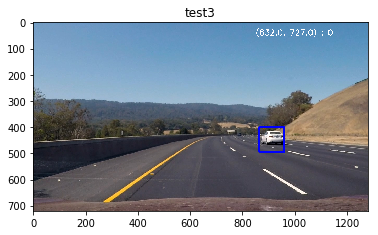

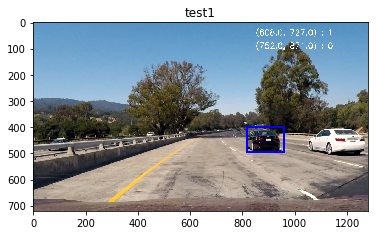

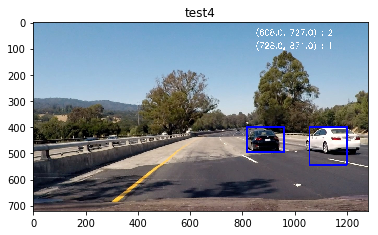

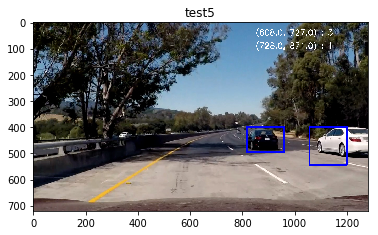

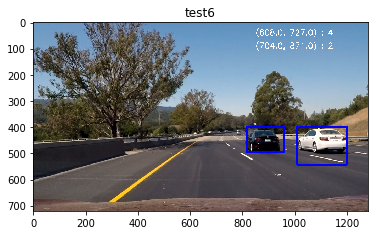

done


In [149]:
vehicles = []
o1= pipeline(mpimg.imread('test_images/test3.jpg'))
image_display(o1,'test3')
o1=pipeline(mpimg.imread('test_images/test1.jpg'))
image_display(o1, 'test1')
# o1=pipeline(mpimg.imread('test_images/test2.jpg'))
# image_display(o1,'test2')
o1=pipeline(mpimg.imread('test_images/test4.jpg'))
image_display(o1,'test4')
o1=pipeline(mpimg.imread('test_images/test5.jpg'))
image_display(o1,'test5')
o1=pipeline(mpimg.imread('test_images/test6.jpg'))
image_display(o1,'test6')
print('done')


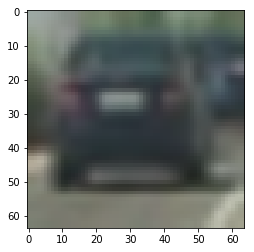

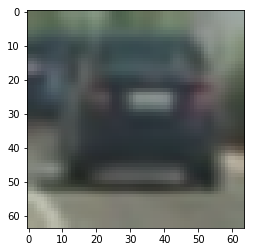

In [74]:
image = mpimg.imread('vehicles/GTI_Far/image0000.png')
image_display(image)
flipped_image = np.fliplr(image)
image_display(flipped_image)


In [150]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
vehicles = []
video_output = 'project_output.mp4'
clip = VideoFileClip('project_video.mp4')
sub_clip = clip.subclip('00:00:35','00:00:45')
project_clip = sub_clip.fl_image(pipeline)
%time project_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4



 62%|██████▏   | 155/251 [01:52<01:09,  1.37it/s]


100%|█████████▉| 250/251 [03:02<00:00,  1.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 3min 15s, sys: 3.68 s, total: 3min 18s
Wall time: 3min 3s


In [151]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))